Hyperparameter-Tuned Estimation of Popcorn Kernel Popping Rates
==========

In [1]:
import pandas as pd
import numpy as np
seed = 42
df = pd.read_csv('./Data/popcorn_pops_custom.csv') # data is computer-generated by ChatGPT under the following assumptions:
    # most kernels pop between 60-75 seconds
    ## some pop earlier ~30-60 seconds 
    ### some pop late ~75-120 seconds
df['pop_time_seconds'] = df['pop_time_seconds'].apply(lambda x: np.random.normal(150,20) if x < 20 else x) # Replace popping times <20 with > 120
df['trial'] = df['trial'] + 1

In [3]:
import random
random.seed(42)

# 3:1 train/test split 
sample = random.sample(range(1, 40), 30)
train = pd.DataFrame()
for trial in sample:
    trial = df[df['trial'] == trial]
    train = pd.concat([train,trial])

test = pd.DataFrame()
for i in range(max(df['trial'])): 
    if i not in sample:
        trial = df[df['trial'] == i ]
        test = pd.concat([test,trial])

In [8]:
# CDF of Popped Kernels for Training Set
time = np.arange(0, 180.01, 0.01)
pops = np.zeros((len(sample), len(time)))

for i, trial in enumerate(sample):
    pop_times = df[df['trial'] == trial]['pop_time_seconds'].values
    # Sort pop times for cumulative counting
    pop_times = np.sort(pop_times)

    # Count how many pop times are ≤ each time point
    pops[i] = np.searchsorted(pop_times, time, side='right')
    pops[i] = pops[i]/np.max(pops[i]) # normalized by total kernels (max popped)

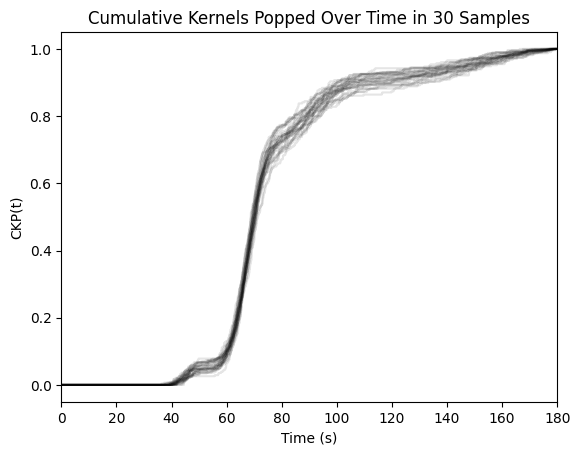

In [12]:
## Discrete Cumulutive Disitrubtion Function (CDF) of Popped Kernels
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
for i in range(len(pops)):
    plt.plot(time, pops[i], alpha = 0.1, color = "black")
plt.xlabel("Time (s)")
plt.ylabel("CKP(t)")
plt.xlim(0,180)
plt.title("Cumulative Kernels Popped Over Time in 30 Samples")
plt.show()

Now that we've split our data into a 3:1 training/test, we'll tune a spline model onto our training data, adjusting the smoothness hyperparameter $s$. Within the training set, leave-one-out cross validation (LOOCV) across trials in our training set. Once we've constructed and validated our spline model, we'll use it to predict exit times for kernel popping.  

In [13]:
import statsmodels.api as sm
from scipy.stats import t
import scipy.stats as stats
from itertools import combinations
from scipy.interpolate import UnivariateSpline
from sklearn.metrics import mean_squared_error
from tqdm import tqdm


In [178]:
# non-parametric regression on cumulative counts using one smoothing spline
# Hyperparameter tuning on smoothness s across each trial's CDF 
# executable: train_spline_model.py stored in ./Model/spline_model.pkl
    # n_trials, n_timepoints = pops.shape
    # s_grid = np.logspace(-1, 4, 20)  # try a range of smoothing factors
    # errors = []

    # for s in tqdm(s_grid):
    #     fold_mse = []

    #     for i in range(n_trials):
    #         # Leave-one-out split
    #         train_cdfs = np.delete(pops, i, axis=0)
    #         val_cdf = pops[i]

    #         # Fit spline on mean of training trials
    #         y_train_mean = np.mean(train_cdfs, axis=0)
    #         spline = UnivariateSpline(time, y_train_mean, s=s)

    #         # Evaluate on validation trial
    #         y_pred = spline(time)
    #         mse = mean_squared_error(val_cdf, y_pred)
    #         fold_mse.append(mse)

    #     errors.append(np.mean(fold_mse))

    # best_s = s_grid[np.argmin(errors)]
    # print(f"Optimal smoothing factor: {best_s:.4f}")


100%|██████████| 20/20 [14:16<00:00, 42.80s/it]  

Optimal smoothing factor: 885.8668


/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_12418/227051391.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(time, spline_model(time), 'k', linewidth=4, color = "blue", alpha = 0.3)


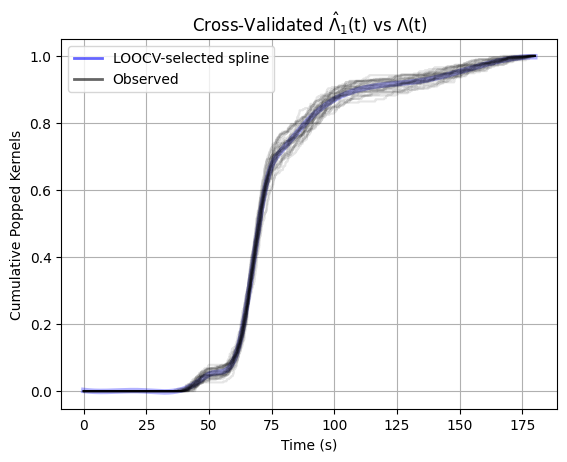

In [15]:
import joblib

# Load model
spline_model = joblib.load("./Model/spline_model.pkl")

# Predict CDF of Kernels Popped
time = np.arange(0, 180.01, 0.01)

# Plot LOOCV-selected spline
plt.plot(time, spline_model(time), 'k', linewidth=4, color = "blue", alpha = 0.3)

# Plot a few sample trial CDFs
for i in range(len(pops)):
    plt.plot(time, pops[i], alpha = 0.1, color = "black")
    
custom_lines = [
    Line2D([0], [0], color='blue', lw=2, label="LOOCV-selected spline", alpha = 0.6),
    Line2D([0], [0], color='black', lw=2, label="Observed", alpha = 0.6)
]

plt.title(r'Cross-Validated $\hat{\Lambda}_{1}$(t) vs $\Lambda$(t)')
plt.xlabel("Time (s)")
plt.ylabel("Cumulative Popped Kernels")
plt.legend(handles = custom_lines)
plt.grid(True)
plt.show()


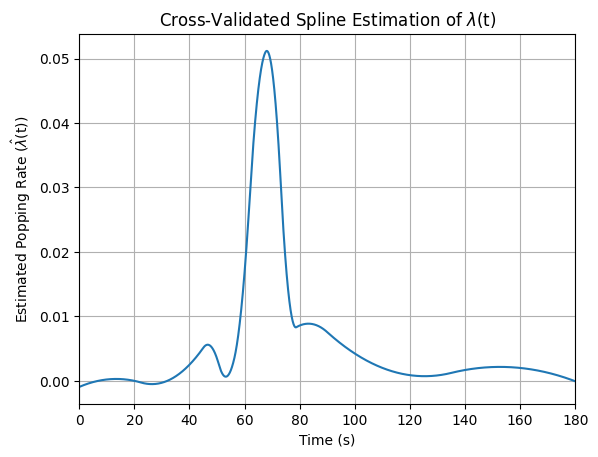

In [17]:
# estimation of lambda(t) via non-parametric regression using LOOCV-spline model
Lambda_hat = spline_model(time)
lambda_hat = spline_model.derivative()(time) # differentiate Lambda(t) to get lambda(t)

plt.plot(time, lambda_hat, label=r'$\hat{\lambda}(t)$')
plt.xlabel("Time (s)")
plt.ylabel(r"Estimated Popping Rate ($\hat{\lambda}$(t))")
plt.title(r"Cross-Validated Spline Estimation of $\lambda$(t)")
plt.grid()
plt.xlim(0,180)
# plt.ylim(-0.5,20)
plt.show()

From here, we can use this model and cross-validate on the remaining test data to see if we can accurately predict when to stop waiting for popcorn by minimizing residual unpopped kernels and burnt popcorn. 
-----

Now we'll test the trained model to optimize lifetime of popped kernels and residual unpopped kernels.

In [44]:
# CDF of Popped Kernels for Testing Set
pops_test = np.zeros((len(sample), len(time)))

for i, trial in enumerate(test['trial'].unique()):
    pop_times = df[df['trial'] == trial]['pop_time_seconds'].values
    # Sort pop times for cumulative counting
    pop_times = np.sort(pop_times)

    # Count how many pop times are ≤ each time point
    pops_test[i] = np.searchsorted(pop_times, time, side='right')
    pops_test[i] = pops_test[i]/np.max(pops_test[i]) # normalized by total kernels (max popped)

In [70]:
pop_times

array([ 41.004     ,  41.967     ,  42.614     ,  43.924     ,
        45.855     ,  46.233     ,  46.331     ,  46.475     ,
        46.938     ,  47.074     ,  47.107     ,  47.727     ,
        48.284     ,  49.079     ,  49.872     ,  52.524     ,
        54.86      ,  56.075     ,  56.478     ,  57.086     ,
        57.099     ,  57.41      ,  57.582     ,  58.171     ,
        58.35      ,  58.791     ,  58.895     ,  58.966     ,
        59.121     ,  59.529     ,  59.786     ,  59.805     ,
        59.896     ,  59.902     ,  60.089     ,  60.339     ,
        60.482     ,  60.578     ,  60.818     ,  61.012     ,
        61.072     ,  61.235     ,  61.257     ,  61.341     ,
        61.367     ,  61.409     ,  61.412     ,  61.576     ,
        61.631     ,  62.016     ,  62.104     ,  62.396     ,
        62.588     ,  62.59      ,  62.627     ,  62.671     ,
        62.7       ,  62.801     ,  63.054     ,  63.114     ,
        63.228     ,  63.237     ,  63.278     ,  63.28

In [67]:
i = 0 
arrival_times = 
for trial in enumerate(test['trial'].unique()):
    

array([ 4, 11, 12, 24, 29, 31, 32, 34, 36])

In [79]:

# Initialize output arrays
pops = np.zeros((len(sample), len(time)))       # Normalized CDFs
max_ages = np.zeros((len(sample), len(time)))   # Max age of any popped kernel

for i, trial in enumerate(sample):
    pop_times = df[df['trial'] == trial]['pop_time_seconds'].values
    pop_times = np.sort(pop_times)

    # CDF: how many kernels popped at or before each time
    pops_i = np.searchsorted(pop_times, time, side='right')
    pops[i] = pops_i / np.max(pops_i)  # Normalize

    # Max age computation
    for j, t in enumerate(time):
        if np.any(pop_times <= t):
            max_ages[i, j] = t - np.min(pop_times[pop_times <= t])
        else:
            max_ages[i, j] = 0

# `pops`: normalized CDFs
# `max_ages`: max age of any popped kernel at each time point


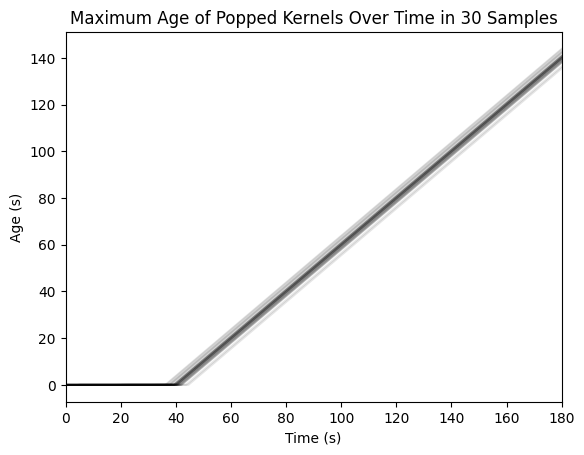

In [84]:
## Discrete Cumulutive Disitrubtion Function (CDF) of Popped Kernels
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
for i in range(len(pops)):
    plt.plot(time, max_ages[i], alpha = 0.1, color = "black")
plt.xlabel("Time (s)")
plt.ylabel("Age (s)")
plt.xlim(0,180)
plt.title("Maximum Age of Popped Kernels Over Time in 30 Samples")
plt.show()